In [12]:
import torch
from torch import nn
import dltools

In [13]:
batch_size, max_len = 1, 64
train_iter, vocab = dltools.load_data_wiki(batch_size, max_len)

In [14]:
# tokens, segments, valid_lens, pred_positions, mlm_weights,mlm, nsp
for i in train_iter:
    break
i

[tensor([[    3,     5,     0,    13,  7116,     8,     9,     2,     2,    60,
           2873,    13,  1591,     4,    37,     2,    11,   732,     7, 11427,
           6722,    27,     5,   161,  1160,    17,  4783,    33,     2,   157,
           1488,     4,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([32.]),
 tensor([[ 2,  7,  8, 15, 28,  0,  0,  0,  0,  0]]),
 tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]]),
 tensor([[7591, 2846,   11,  540, 7955,    0,    0,    0,    0,    0]]),
 tensor([1])]

In [4]:
net = dltools.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = dltools.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [5]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,segments_X, valid_lens_x,pred_positions_X, mlm_weights_X,mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,valid_lens_x.reshape(-1),pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [6]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, dltools.Timer()
    animator = dltools.Animator(xlabel='step', ylabel='loss',xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = dltools.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,(metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, 'f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on 'f'{str(devices)}')

MLM loss 5.945, NSP loss 1.095
43.4 sentence pairs/sec on [device(type='cuda', index=0)]


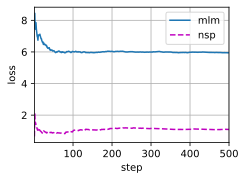

In [15]:
train_bert(train_iter, net, loss, len(vocab), devices, 500)

In [16]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = dltools.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [17]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-2.2683,  0.7571,  0.7458], device='cuda:0', grad_fn=<SliceBackward0>))

In [10]:
encoded_text_crane

tensor([[-0.2327, -0.9581,  0.3251,  0.4313,  1.9039,  2.5240,  0.2025,  1.2935,
         -0.9396,  0.9388,  0.0984, -0.1372, -0.3209, -0.8752, -0.9859,  0.5817,
         -0.8799, -0.8362,  0.3150,  1.8696,  1.0286, -0.3185,  0.2066,  0.2558,
          0.3261,  0.3828, -0.0475,  0.4127, -0.1402, -0.6605, -1.9259, -1.0924,
          0.2851, -0.0805,  0.0233, -0.7216,  1.0532,  1.0929, -0.3400, -0.4744,
          0.2879,  1.0464,  1.2938, -0.8487,  0.4252,  0.0696,  0.8107, -1.9805,
          0.1688,  0.4681, -1.9278,  0.0463, -1.8961,  0.4219,  0.6491, -0.1465,
          0.1290,  1.2615,  0.4138, -0.5519,  1.8082,  0.3073,  2.3432,  1.9259,
          0.2739, -1.6102,  0.0747, -0.2047, -1.2654, -1.9331, -1.5496, -0.2510,
          0.1072, -0.0317,  0.1552, -1.1012, -0.2511,  0.6096,  1.0332, -0.5527,
          0.4854,  0.4941, -0.6280,  2.0186, -0.1956,  0.7794, -0.8140,  1.5922,
         -0.1524,  0.1068,  0.8384,  0.1546, -1.5382, -0.5664, -1.2311,  0.9542,
         -1.3234, -1.8820,  

In [18]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.9853,  0.7458,  0.6612], device='cuda:0', grad_fn=<SliceBackward0>))